In [131]:
from collections import Counter
import numpy as np
import pandas as pd
import Levenshtein  # pip install python-Levenshtein
import re
from collections import Counter
import Levenshtein
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats as stats



In [132]:
# Show all columns
pd.set_option('display.max_columns', None)

# Show all rows
pd.set_option('display.max_rows', None)

# Prevent truncating column content
pd.set_option('display.max_colwidth', None)  # For pandas < 1.0 use -1 instead of None


In [133]:
data = pd.read_csv('1.csv')

In [134]:
data.head(10)

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT
0,7/31/2019,1x Dual Sim,Alcatel 1x Dual Sim,alcatel,Google,Android,Smartphone,Y,Y,Y,Y,Y,Y,Y,Female,26-35,NaN,nan,Non-Saudi,4
1,3/31/2019,K7 Dual Sim,LG K7 Dual Sim,LG,Google,Android,Smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1
2,11/30/2019,ELUGA I3,Panasonic ELUGA I3,Panasonic,Google,Androxd,Smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1
3,8/31/2019,M98,HEDY M98,hedy,HEDY,Proprietary,Mobile Phone,Y,N,N,N,Y,N,N,Female,36-55,YEM,Yemen,Non-Saudi,3
4,12/31/2019,|105,Nokia 105,NOKIA,Nokia,Proprietary,Mobile Phone,Y,N,N,N,N,N,N,Male,NA,IND,India,Non-Saudi,3758
5,1/31/2020,One Touch 1050 Dual Sim,Alcatel One Touch 1050 Dual Sim,ALCATEL,Alcatel,Proprietary,Mobile Phone,Y,N,N,N,N,N,Y,Male,36-55,BHR,Bahrain,Non-Saudi,1
6,2/29/2020,Moto M# Dual Sim,Motorola Moto M Dual Sim,MOTOROLA,Google,Androiy,Smartphone,Y,Y,Y,Y,Y,Y,Y,Female,>55,SYR,Syria,Non-Saudi,1
7,2/29/2020,K802,Kaliho K802,kaliho,Google,Android,Smartphone,Y,Y,N,NaN,Y,Y,Y,Male,18-25,IDN,Indonesia,Non-Saudi,1
8,1/31/2019,T528,Tecno T528,tecno,Tecno Technology,NaN,Mobile Phone,Y,N,N,N,Y,N,Y,Male,NA,NGA,Nigerian,Non-Saudi,14
9,12/31/2019,2310,Nokia 2310,NOKIA,Nokia,Proprietary,Mobile Phone,Y,N,N,N,N,N,N,Female,36-55,PHL,Philippines,Non-Saudi,5


In [135]:
df=data.copy()

# Remove Special characters

In [136]:
flag_cols = ['_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

# Standardize the flag values
for col in flag_cols:
    df[col] = df[col].astype(str).str.strip().str.lower().map({
        'yes': 'y', 'no': 'n',
        'Y': 'y', 'N': 'n'
    }).fillna(df[col])


In [137]:
df['DEVICE_COUNT'] = df['DEVICE_COUNT'].replace('ten', 10)


In [138]:
df = df.applymap(lambda x: re.sub(r'\s+', ' ', str(x).strip()) if isinstance(x, str) else x)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_10776\2478850691.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: re.sub(r'\s+', ' ', str(x).strip()) if isinstance(x, str) else x)


In [139]:
cols_to_lower = ['MODEL_NAME', 'BRAND_FULL_NAME', 'BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']

for col in cols_to_lower:
    df[col] = df[col].apply(lambda x: x.lower() if isinstance(x, str) else x)


In [140]:
# Replace values that are: nan/NA/unknown (case-insensitive) or only whitespace
df = df.applymap(
    lambda x: np.nan if isinstance(x, str) and x.strip().lower() in ['nan', 'na', 'unknown', ''] else x
)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_10776\490592483.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


In [141]:
cols_to_clean = ['MODEL_NAME', 'BRAND_FULL_NAME', 'BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']

for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(' | ', '', regex=False)


for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(' |', '', regex=False)


for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace('|', '', regex=False)


# Step 1: Remove unwanted characters (except parentheses)
symbol_pattern = r"[!@#$%^&*_=\{\};:'\"<>,.?/\\|`~\[\]]"  # Adjusted to include more symbols

# Step 2: Remove unmatched ( or )
def remove_unmatched_parens(text):
    if not isinstance(text, str):
        return text

    # Count opening and closing
    open_count = text.count('(')
    close_count = text.count(')')

    # If unmatched '(', remove it
    if open_count > close_count:
        text = text.replace('(', '')
    # If unmatched ')', remove it
    if close_count > open_count:
        text = text.replace(')', '')

    return text

# Apply both cleaning steps
for col in cols_to_clean:
    df[col] = df[col].apply(lambda x: re.sub(symbol_pattern, '', x) if isinstance(x, str) else x)
    df[col] = df[col].apply(remove_unmatched_parens)


In [142]:
# Cleaning function: remove '+' only if not at the end
def clean_plus(text):
    if isinstance(text, str):
        return re.sub(r'\+(?=\w)', '', text)
    return text

# Apply the function to each column
for col in cols_to_lower:
    df[col] = df[col].apply(clean_plus)

In [143]:
# Replace values that are: nan/NA/unknown (case-insensitive) or only whitespace
df = df.applymap(
    lambda x: np.nan if isinstance(x, str) and x.strip().lower() in ['nan', 'na', 'unknown', ''] else x
)


C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_10776\1795654457.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


# Correct Names and misspelling

In [144]:
# This function corrects similar values in a specified column of a DataFrame
# using Levenshtein distance to group similar strings and replace them with the most frequent value

def correct_similar_values(df, column, max_distance=2):
    print(f"Cleaning column: '{column}'")

    # Step 1: Drop NaNs and prepare the value list
    values = df[column].dropna().astype(str).str.strip()
    frequencies = Counter(values)
    unique_values = list(frequencies.keys())
    visited = set()
    corrections = {}

    # Step 2: Compare all pairs to find similar groups
    for i, val1 in enumerate(unique_values):
        if val1 in visited:
            continue
        group = [val1]
        for val2 in unique_values[i+1:]:
            if val2 in visited:
                continue
            if Levenshtein.distance(val1.lower(), val2.lower()) <= max_distance:
                group.append(val2)
                visited.add(val2)
        visited.add(val1)

        # Pick the most frequent value in the group
        if len(group) > 1:
            canonical = max(group, key=lambda x: frequencies[x])
            for val in group:
                if val != canonical:
                    corrections[val] = canonical

    # Step 3: Apply corrections
    df_cleaned = df.copy()
    df_cleaned[column] = df_cleaned[column].apply(lambda x: corrections.get(x, x) if isinstance(x, str) else x)

    print(f"Unique values reduced: {df[column].nunique()} → {df_cleaned[column].nunique()}")
    return df_cleaned, corrections

In [145]:
columns_to_fix = ['NATIONALITY_NAME', 'SAUDI_NON_SAUDI', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE', 'BRAND_NAME']

for col in columns_to_fix:
    df, fixes = correct_similar_values(df, column=col)

Cleaning column: 'NATIONALITY_NAME'
Unique values reduced: 1622 → 206
Cleaning column: 'SAUDI_NON_SAUDI'
Unique values reduced: 2 → 2
Cleaning column: 'VENDOR_NAME'
Unique values reduced: 860 → 107
Cleaning column: 'OS_NAME'
Unique values reduced: 203 → 9
Cleaning column: 'DEVICE_TYPE'
Unique values reduced: 2 → 2
Cleaning column: 'BRAND_NAME'
Unique values reduced: 1193 → 168


In [146]:
df.OS_NAME.value_counts()

OS_NAME
android           114722
proprietary        67555
symbian             6772
other               4882
rim os              2082
windows phone       1901
blackberry os       1016
uyknown               37
windows mobile        35
Name: count, dtype: int64

In [147]:
# Fix the logic to correctly replace 'uyknown' with 'unknown' in OS_NAME
df.loc[df['OS_NAME'] == 'uyknown', 'OS_NAME'] = 'unknown'

In [148]:
df.OS_NAME.value_counts()

OS_NAME
android           114722
proprietary        67555
symbian             6772
other               4882
rim os              2082
windows phone       1901
blackberry os       1016
unknown               37
windows mobile        35
Name: count, dtype: int64

In [149]:
# Replace values that are: nan/NA/unknown (case-insensitive) or only whitespace
df = df.applymap(
    lambda x: np.nan if isinstance(x, str) and x.strip().lower() in ['nan', 'na', 'unknown', ''] else x
)


C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_10776\1795654457.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


In [150]:
df.BRAND_NAME.value_counts()

BRAND_NAME
nokia               63089
htc                 14383
lenovo              13025
lg                  11275
sony                10356
xiaomi              10331
alcatel              9297
oppo                 6289
vivo                 5198
lava                 5065
tecno                4835
motorola             4695
panasonic            4269
oneplus              3012
four                 2891
infinix              2794
rim                  2056
mione                1837
asus                 1709
symphony             1683
philips              1610
blackberry           1582
microsoft            1115
micromax             1022
bocoin               1017
innjoo               1012
darago                752
google                666
sony ericsson         644
qmobile               550
star                  544
eurostar  device      533
realme                435
xtouch                422
iku                   377
hope                  347
fero                  341
energizer             323
k

In [151]:
# Define the corrections
brand_corrections = {
    'cecz': 'cect',
    'hzc': 'htc',
    'ityl': 'itzl',
    'miyne': 'mione',
    'mphzne': 'mphone',
    'sict': 'sico',
    'wyko': 'wiko',
    'xltzl': 'xltel'
}

# Apply corrections to the 'BRAND_NAME' column
df['BRAND_NAME'] = df['BRAND_NAME'].replace(brand_corrections)


In [152]:
df['VENDOR_NAME'] = df['VENDOR_NAME'].replace(r'(?i)^goo$', 'google', regex=True)

# Outliers

In [153]:
df.DEVICE_COUNT.head().value_counts()

DEVICE_COUNT
1       2
4       1
3       1
3758    1
Name: count, dtype: int64

In [154]:
data['DEVICE_COUNT'].isna().sum()

np.int64(2052)

In [155]:
#Because there was 'ten' string
df['DEVICE_COUNT'] = pd.to_numeric(df['DEVICE_COUNT'], errors='coerce').astype('Int64')

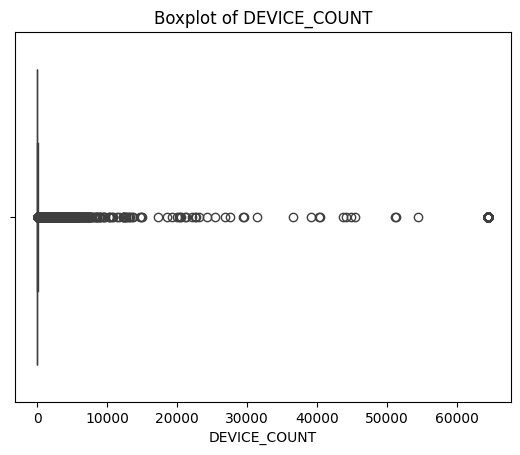

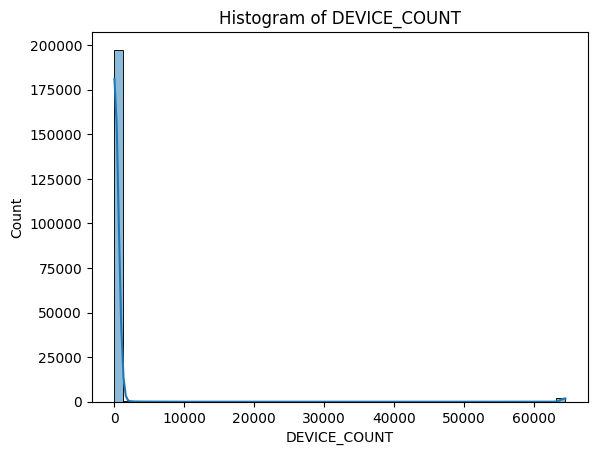

In [156]:
sns.boxplot(x=df['DEVICE_COUNT'])
plt.title("Boxplot of DEVICE_COUNT")
plt.show()

sns.histplot(df['DEVICE_COUNT'], bins=50, kde=True)
plt.title("Histogram of DEVICE_COUNT")
plt.show()


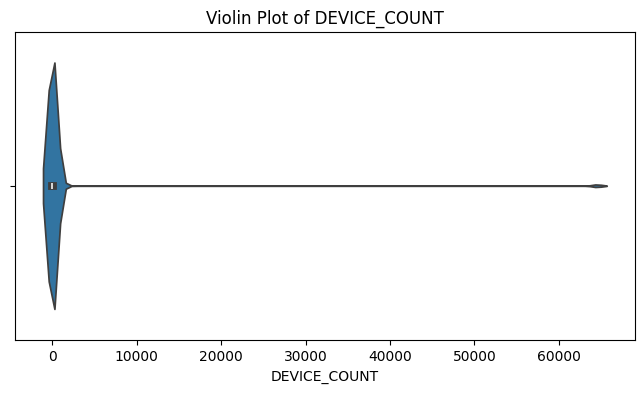

In [157]:
plt.figure(figsize=(8, 4))
sns.violinplot(x=df['DEVICE_COUNT'])
plt.title("Violin Plot of DEVICE_COUNT")
plt.xlabel("DEVICE_COUNT")
plt.show()

In [158]:
Q1 = df['DEVICE_COUNT'].quantile(0.25)
Q3 = df['DEVICE_COUNT'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['DEVICE_COUNT'] < lower_bound) | (df['DEVICE_COUNT'] > upper_bound)]
print(f"Outliers found: {len(outliers)}")


Outliers found: 29700


In [159]:
df.OS_NAME.value_counts()

OS_NAME
android           114722
proprietary        67555
symbian             6772
other               4882
rim os              2082
windows phone       1901
blackberry os       1016
windows mobile        35
Name: count, dtype: int64

In [160]:
df.DEVICE_TYPE.value_counts()

DEVICE_TYPE
smartphone      127748
mobile phone     72188
Name: count, dtype: int64

In [161]:
df.BRAND_NAME.value_counts()

BRAND_NAME
nokia               63089
htc                 14587
lenovo              13025
lg                  11275
sony                10356
xiaomi              10331
alcatel              9297
oppo                 6289
vivo                 5198
lava                 5065
tecno                4835
motorola             4695
panasonic            4269
oneplus              3012
four                 2891
infinix              2794
rim                  2056
mione                1876
asus                 1709
symphony             1683
philips              1610
blackberry           1582
microsoft            1115
micromax             1022
bocoin               1017
innjoo               1012
darago                752
google                666
sony ericsson         644
qmobile               550
star                  544
eurostar  device      533
realme                435
xtouch                422
iku                   377
hope                  347
fero                  341
energizer             323
k

In [162]:
from sklearn.preprocessing import RobustScaler

def replace_outliers_with_scaled_safe(data, outlier_method='iqr'):
    """
    Apply RobustScaler with data cleaning and outlier replacement
    """
    # Clean data first
    clean_data = pd.to_numeric(data, errors='coerce')
    
    # Remove NaN values for processing
    valid_mask = clean_data.notna()
    valid_data = clean_data[valid_mask]
    
    if len(valid_data) == 0:
        return data.copy(), pd.Series(False, index=data.index)
    
    # Step 1: Identify outliers
    if outlier_method == 'iqr':
        Q1 = valid_data.quantile(0.25)
        Q3 = valid_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_mask = (valid_data < lower_bound) | (valid_data > upper_bound)
    
    elif outlier_method == 'zscore':
        z_scores = np.abs((valid_data - valid_data.mean()) / valid_data.std())
        outlier_mask = z_scores > 3
    
    # Step 2: Apply RobustScaler to valid data
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(valid_data.values.reshape(-1, 1)).flatten()
    
    # Step 3: Create result
    result = clean_data.copy()
    result[valid_mask] = valid_data  # Keep original non-outliers
    result = result.astype(float)  # Add this before assignment
    result[valid_mask & outlier_mask] = scaled_data[outlier_mask]  # Replace outliers
    
    return result, outlier_mask

# Usage
df['DEVICE_COUNT_processed'], outliers_mask = replace_outliers_with_scaled_safe(df['DEVICE_COUNT'])

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_10776\2363318935.py:38: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  result[valid_mask & outlier_mask] = scaled_data[outlier_mask]  # Replace outliers


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202000 entries, 0 to 201999
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CAL_DT                  199946 non-null  object 
 1   MODEL_NAME              199942 non-null  object 
 2   BRAND_FULL_NAME         199947 non-null  object 
 3   BRAND_NAME              199941 non-null  object 
 4   VENDOR_NAME             199009 non-null  object 
 5   OS_NAME                 198965 non-null  object 
 6   DEVICE_TYPE             199936 non-null  object 
 7   _2G_FLG                 199933 non-null  object 
 8   _3G_FLG                 199932 non-null  object 
 9   _4G_FLG                 199931 non-null  object 
 10  WIFI_FLG                199946 non-null  object 
 11  BLUETOOTH_FLG           199955 non-null  object 
 12  TOUCH_SCREEN_FLG        199938 non-null  object 
 13  DUAL_SIM_FLG            199943 non-null  object 
 14  GENDER_TYPE_CD      

In [164]:
# Now this should work
print("Outliers before and after:")
threshold = df['DEVICE_COUNT_processed'].quantile(0.95)
outliers_mask = (df['DEVICE_COUNT_processed'] > threshold)

comparison = pd.DataFrame({
    'Original': df['DEVICE_COUNT'].head(10),
    'Processed': df['DEVICE_COUNT_processed'].head(10)
})
print(comparison)

Outliers before and after:
   Original  Processed
0         4        4.0
1         1        1.0
2         1        1.0
3         3        3.0
4      3758      626.0
5         1        1.0
6         1        1.0
7         1        1.0
8        14       14.0
9         5        5.0


# Fill null

In [165]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
0,7/31/2019,1x dual sim,alcatel 1x dual sim,alcatel,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Female,26-35,NaN,NaN,Non-Saudi,4,4.0
1,3/31/2019,k7 dual sim,lg k7 dual sim,lg,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1,1.0
2,11/30/2019,eluga i3,panasonic eluga i3,panasonic,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1,1.0
3,8/31/2019,m98,hedy m98,hedy,hedy,proprietary,mobile phone,Y,N,N,N,Y,N,N,Female,36-55,YEM,Yemen,Non-Saudi,3,3.0
4,12/31/2019,105,nokia 105,nokia,nokia,proprietary,mobile phone,Y,N,N,N,N,N,N,Male,NaN,IND,India,Non-Saudi,3758,626.0


In [166]:
df.isna().sum()

CAL_DT                     2054
MODEL_NAME                 2058
BRAND_FULL_NAME            2053
BRAND_NAME                 2059
VENDOR_NAME                2991
OS_NAME                    3035
DEVICE_TYPE                2064
_2G_FLG                    2067
_3G_FLG                    2068
_4G_FLG                    2069
WIFI_FLG                   2054
BLUETOOTH_FLG              2045
TOUCH_SCREEN_FLG           2062
DUAL_SIM_FLG               2057
GENDER_TYPE_CD            25834
AGE_B                     32870
NATIONALITY_CD            22513
NATIONALITY_NAME          22512
SAUDI_NON_SAUDI            2052
DEVICE_COUNT               2052
DEVICE_COUNT_processed     2052
dtype: int64

In [167]:
df.DEVICE_TYPE.value_counts()

DEVICE_TYPE
smartphone      127748
mobile phone     72188
Name: count, dtype: int64

In [168]:
# Clean NATIONALITY_CD
df['NATIONALITY_CD'] = df['NATIONALITY_CD'].apply(
    lambda x: x.strip().upper() if isinstance(x, str) else x
)

# Clean NATIONALITY_NAME
df['NATIONALITY_NAME'] = df['NATIONALITY_NAME'].apply(
    lambda x: x.strip().title() if isinstance(x, str) else x
)

# Clean SAUDI_NON_SAUDI
df['SAUDI_NON_SAUDI'] = df['SAUDI_NON_SAUDI'].apply(
    lambda x: x.strip().title() if isinstance(x, str) else x
)


In [169]:
df['SAUDI_NON_SAUDI'] = np.where(
    (df['NATIONALITY_CD'] == 'SAU') | (df['NATIONALITY_NAME'] == 'Saudi Arabia'),
    'Saudi',
    df['SAUDI_NON_SAUDI']
)

In [170]:
df['NATIONALITY_CD'] = np.where(
    (df['SAUDI_NON_SAUDI'] == 'Saudi') | (df['NATIONALITY_NAME'] == 'Saudi Arabia'),
    'SAU',
    df['NATIONALITY_CD']
)


In [171]:
df['NATIONALITY_NAME'] = np.where(
    (df['SAUDI_NON_SAUDI'] == 'Saudi') | (df['NATIONALITY_CD'] == 'SAU'),
    'Saudi Arabia',
    df['NATIONALITY_NAME']
)


In [172]:
df.columns

Index(['CAL_DT', 'MODEL_NAME', 'BRAND_FULL_NAME', 'BRAND_NAME', 'VENDOR_NAME',
       'OS_NAME', 'DEVICE_TYPE', '_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG',
       'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG', 'GENDER_TYPE_CD',
       'AGE_B', 'NATIONALITY_CD', 'NATIONALITY_NAME', 'SAUDI_NON_SAUDI',
       'DEVICE_COUNT', 'DEVICE_COUNT_processed'],
      dtype='object')

Fix CutOff and mispelling of Model Name

In [173]:
# 1. Make sure model_name and BRAND_NAME are strings
df['MODEL_NAME'] = df['MODEL_NAME'].astype(str).replace('nan', np.nan)
df['BRAND_NAME'] = df['BRAND_NAME'].astype(str).replace('nan', np.nan)
df['BRAND_FULL_NAME'] = df['BRAND_FULL_NAME'].astype(str).replace('nan', np.nan)

# 2. Create unique list of brand names
unique_brands = df['BRAND_NAME'].dropna().unique().tolist()

# 3. Helper function to extract model from BRAND_FULL_NAME
def extract_model(row):
    brand = row['BRAND_NAME']
    full = row['BRAND_FULL_NAME']
    model = row['MODEL_NAME']
    
    # CASE 1: MODEL_NAME is NOT null
    if pd.notnull(model) and pd.notnull(full):
        # remove BRAND_NAME from BRAND_FULL_NAME
        for b in unique_brands:
            if full.startswith(b + ' '):
                expected_model = full[len(b):].strip()
                if model.strip() != expected_model:
                    return expected_model  # fix incorrect model
                return model.strip()
        return model.strip()
    
    # CASE 2: MODEL_NAME is null but BRAND_FULL_NAME exists
    if pd.isnull(model) and pd.notnull(full):
        for b in unique_brands:
            if full.startswith(b + ' '):
                return full[len(b):].strip()
        return full.strip()  # fallback if brand not matched
    
    return np.nan  # model still unknown

# Apply the function to fix MODEL_NAME
df['MODEL_NAME_fixed'] = df.apply(extract_model, axis=1)

# Group columns for filling remaining nulls
group_cols = [
    'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE', '_2G_FLG', '_3G_FLG',
    '_4G_FLG', 'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG',
    'DUAL_SIM_FLG', 'GENDER_TYPE_CD'
]

# Function to get mode value per group
def fill_model_mode(group):
    mode_val = group['MODEL_NAME_fixed'].mode()
    if not mode_val.empty:
        group['MODEL_NAME_fixed'] = group['MODEL_NAME_fixed'].fillna(mode_val.iloc[0])
    return group

# Apply group-wise mode filling
df = df.groupby(group_cols, dropna=False).apply(fill_model_mode).reset_index(drop=True)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_10776\1419724558.py:53: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(group_cols, dropna=False).apply(fill_model_mode).reset_index(drop=True)


In [174]:
df['MODEL_NAME'] = df['MODEL_NAME_fixed']
df.drop(columns=['MODEL_NAME_fixed'], inplace=True)

In [175]:
# Function to infer BRAND_NAME from BRAND_FULL_NAME
def fill_brand_from_full(row):
    brand = row['BRAND_NAME']
    full = row['BRAND_FULL_NAME']
    
    if pd.isnull(brand) and pd.notnull(full):
        for b in unique_brands:
            if full.startswith(b + ' ') or full == b:
                return b
    return brand

# Apply function to fill missing BRAND_NAME
df['BRAND_NAME'] = df.apply(fill_brand_from_full, axis=1)

In [176]:
# Fill brand_full_name when null by combining brand_name and model_name
df['BRAND_FULL_NAME'] = df.apply(
    lambda row: f"{row['BRAND_NAME']} {row['MODEL_NAME']}".strip() 
    if pd.isnull(row['BRAND_FULL_NAME']) and pd.notnull(row['BRAND_NAME']) and pd.notnull(row['MODEL_NAME']) 
    else row['BRAND_FULL_NAME'], axis=1
)

In [177]:
# Define a function to fill nulls with the group's most common DEVICE_TYPE
def fill_device_type(group):
    if group['DEVICE_TYPE'].isnull().any():
        mode = group['DEVICE_TYPE'].mode()
        if not mode.empty:
            group['DEVICE_TYPE'] = group['DEVICE_TYPE'].fillna(mode.iloc[0])
    return group

# Apply the function on each group
df = df.groupby(['OS_NAME', 'VENDOR_NAME'], group_keys=False).apply(fill_device_type)


C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_10776\3383298152.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['OS_NAME', 'VENDOR_NAME'], group_keys=False).apply(fill_device_type)


In [178]:
# Make a copy to avoid modifying original
df_clean = df.copy()

# Step 1: Fill using group-based mode
def fill_vendor_by_group(group):
    if group['VENDOR_NAME'].isnull().any():
        mode = group['VENDOR_NAME'].mode()
        if not mode.empty:
            group['VENDOR_NAME'] = group['VENDOR_NAME'].fillna(mode.iloc[0])
    return group

df_clean = df_clean.groupby(['BRAND_NAME', 'OS_NAME', 'DEVICE_TYPE'], group_keys=False).apply(fill_vendor_by_group)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_10776\4005558391.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby(['BRAND_NAME', 'OS_NAME', 'DEVICE_TYPE'], group_keys=False).apply(fill_vendor_by_group)


In [179]:
# Step 2: Fill remaining nulls by BRAND_NAME only
def fill_vendor_by_brand(group):
    if group['VENDOR_NAME'].isnull().any():
        mode = group['VENDOR_NAME'].mode()
        if not mode.empty:
            group['VENDOR_NAME'] = group['VENDOR_NAME'].fillna(mode.iloc[0])
    return group

df_clean = df_clean.groupby('BRAND_NAME', group_keys=False).apply(fill_vendor_by_brand)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_10776\3384394963.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('BRAND_NAME', group_keys=False).apply(fill_vendor_by_brand)


In [180]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

# Step 3: Fill remaining with KNNImputer
# Select only relevant columns (encode all as numeric)
cols_for_knn = ['BRAND_NAME', 'OS_NAME', 'DEVICE_TYPE', 'VENDOR_NAME']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoded_data = encoder.fit_transform(df_clean[cols_for_knn])

# KNN imputation
imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(encoded_data)

# Restore back only the imputed vendor_name (last column)
df_clean['VENDOR_NAME'] = encoder.inverse_transform(imputed_data)[:, -1]


In [181]:
df.VENDOR_NAME = df_clean.VENDOR_NAME.copy()

In [182]:
df.isna().sum()

CAL_DT                     2005
MODEL_NAME                   26
BRAND_FULL_NAME              37
BRAND_NAME                   84
VENDOR_NAME                  84
OS_NAME                       0
DEVICE_TYPE                   0
_2G_FLG                    2020
_3G_FLG                    2021
_4G_FLG                    2020
WIFI_FLG                   2003
BLUETOOTH_FLG              1999
TOUCH_SCREEN_FLG           2008
DUAL_SIM_FLG               2015
GENDER_TYPE_CD            25275
AGE_B                     32072
NATIONALITY_CD            12910
NATIONALITY_NAME          12925
SAUDI_NON_SAUDI            1895
DEVICE_COUNT               2003
DEVICE_COUNT_processed     2003
dtype: int64

In [183]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))    
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Example:
cramers_v(df['AGE_B'], df['DEVICE_TYPE'])


np.float64(0.06356287647612593)

In [184]:
nat_map = {}

for _, row in df.iterrows():
    cd = row['NATIONALITY_CD']
    name = row['NATIONALITY_NAME']
    
    if pd.notna(cd) and pd.notna(name):
        if cd not in nat_map:
            nat_map[cd] = name


In [185]:
nat_map

{'IDN': 'Indonesia',
 'ERI': 'Eritrea',
 'LKA': 'Sri Lanka',
 'PHL': 'Philippines',
 'BGD': 'Bangladesh',
 'ETH': 'Ethiopia',
 'SAU': 'Saudi Arabia',
 'JOR': 'Jordan',
 'ZAF': 'South Africa',
 'TCD': 'Chad',
 'NGA': 'Nigerian',
 'IND': 'India',
 'EGY': 'Egypt',
 'DZA': 'Algeria',
 'MAR': 'Morocco',
 'SDN': 'Sudan',
 'PAK': 'Pakistan',
 'TUN': 'Tunisia',
 'UZB': 'Uzbekistan',
 'SYR': 'Syria',
 'NPL': 'Nepal',
 'MLI': 'Mali',
 'LBN': 'Lebanon',
 'YEM': 'Yemen',
 'AFG': 'Afghanistan',
 'BRN': 'Brunei',
 'IRL': 'Ireland',
 'NER': 'Niger',
 'KEN': 'Kenya',
 'IRQ': 'Iraq',
 'ALB': 'Albania',
 'SEN': 'Senegal',
 'PSE': 'Palestine',
 'GBR': 'United Kingdom',
 'MYS': 'Malaysia',
 'KWT': 'Kuwait',
 'KAZ': 'Kazakhstan',
 'GHA': 'Ghana',
 'SOM': 'Somalia',
 'BDI': 'Brunei',
 'BFA': 'Burkina Faso',
 'GIN': 'Guinea',
 'KGZ': 'Kyrgyzstan',
 'BHR': 'Bahrain',
 'FRA': 'France',
 'NIC': 'Nicaragua',
 'AIA': 'Anguilla',
 'TUR': 'Turkey',
 'CMR': 'Cameroon',
 'BRB': 'Barbados',
 'AND': 'Andorra',
 'VNM': 

In [186]:
df[df['NATIONALITY_CD'] == 'MAR'].head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
29,8/31/2019,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,36-55,MAR,Morocco,Non-Saudi,1,1.0
272,5/31/2020,one touch 1016 dual sim,alcatel one touch 1016 dual sim,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,Y,Female,36-55,MAR,Morocco,Non-Saudi,1,1.0
298,10/31/2019,one touch 1016 dual sim,alcatel one touch 1016 dual sim,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,Y,Female,36-55,MAR,Morocco,Non-Saudi,1,1.0
357,7/31/2019,1066 dual sim,alcatel 1066 dual sim,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,Y,Female,36-55,MAR,Morocco,Non-Saudi,3,3.0
485,12/31/2019,one touch 1035 dual sim,alcatel one touch 1035 dual sim,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,Y,Female,>55,MAR,Morocco,Non-Saudi,1,1.0


In [187]:
# Step 2: Build reverse dictionary (to fill CD from name)
rev_nat_map = {v: k for k, v in nat_map.items()}

# Step 3: Fill missing values
def fill_nationality(row):
    if pd.isna(row['NATIONALITY_NAME']) and pd.notna(row['NATIONALITY_CD']):
        row['NATIONALITY_NAME'] = nat_map.get(row['NATIONALITY_CD'])
    elif pd.isna(row['NATIONALITY_CD']) and pd.notna(row['NATIONALITY_NAME']):
        row['NATIONALITY_CD'] = rev_nat_map.get(row['NATIONALITY_NAME'])
    return row

# Step 4: Apply row-wise
df = df.apply(fill_nationality, axis=1)


In [188]:
df.isna().sum()

CAL_DT                     2005
MODEL_NAME                   26
BRAND_FULL_NAME              37
BRAND_NAME                   84
VENDOR_NAME                  84
OS_NAME                       0
DEVICE_TYPE                   0
_2G_FLG                    2020
_3G_FLG                    2021
_4G_FLG                    2020
WIFI_FLG                   2003
BLUETOOTH_FLG              1999
TOUCH_SCREEN_FLG           2008
DUAL_SIM_FLG               2015
GENDER_TYPE_CD            25275
AGE_B                     32072
NATIONALITY_CD            11257
NATIONALITY_NAME          11241
SAUDI_NON_SAUDI            1895
DEVICE_COUNT               2003
DEVICE_COUNT_processed     2003
dtype: int64

In [189]:
df.SAUDI_NON_SAUDI.value_counts()

SAUDI_NON_SAUDI
Non-Saudi    174088
Saudi         20949
Name: count, dtype: int64

In [190]:
df['SAUDI_NON_SAUDI'] = df['NATIONALITY_CD'].apply(
    lambda x: 'Saudi' if x == 'SAU' else ('Non-Saudi' if pd.notna(x) else np.nan)
)

In [191]:
df.isna().sum()

CAL_DT                     2005
MODEL_NAME                   26
BRAND_FULL_NAME              37
BRAND_NAME                   84
VENDOR_NAME                  84
OS_NAME                       0
DEVICE_TYPE                   0
_2G_FLG                    2020
_3G_FLG                    2021
_4G_FLG                    2020
WIFI_FLG                   2003
BLUETOOTH_FLG              1999
TOUCH_SCREEN_FLG           2008
DUAL_SIM_FLG               2015
GENDER_TYPE_CD            25275
AGE_B                     32072
NATIONALITY_CD            11257
NATIONALITY_NAME          11241
SAUDI_NON_SAUDI           11257
DEVICE_COUNT               2003
DEVICE_COUNT_processed     2003
dtype: int64

# Try to Solve 'Z'

 in ['WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

In [192]:
columns_with_Z = df.columns[df.isin(['Z']).any()].tolist()
print(columns_with_Z)


['WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']


In [193]:
df_z = df[['WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']].copy()

In [194]:
df[(df['WIFI_FLG'] == 'Z') & (df['BLUETOOTH_FLG'] == 'Z')].head(90)

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
6383,2/29/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,1,1.000000
6384,6/30/2019,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,2,2.000000
6385,9/30/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,1,1.000000
6386,1/31/2019,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,2,2.000000
6387,4/30/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,36-55,BGD,Bangladesh,Non-Saudi,1,1.000000
6388,8/31/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,36-55,BGD,Bangladesh,Non-Saudi,64521,10753.166667
6622,2/29/2020,m1,ck telecom m1,ck telecom,cect,proprietary,mobile phone,Y,N,N,Z,Z,N,Z,Male,>55,SAU,Saudi Arabia,Saudi,2,2.000000
6930,7/31/2019,NaN,NaN,ck telecom,ck telecom,proprietary,mobile phone,Y,N,N,Z,Z,N,Z,Female,>55,SAU,Saudi Arabia,Saudi,1,1.000000
6931,10/31/2019,m1,ck telecom m1,ck telecom,ck telecom,proprietary,mobile phone,Y,N,N,Z,Z,N,Z,Male,36-55,LBN,Lebanon,Non-Saudi,1,1.000000
6932,8/31/2020,m1,ck telecom m1,ck telecom,ck telecom,proprietary,mobile phone,Y,N,N,Z,Z,N,Z,Male,>55,GBR,United Kingdom,Non-Saudi,1,1.000000


In [195]:
df[(df['WIFI_FLG'] == 'Z') & (df['TOUCH_SCREEN_FLG'] == 'Z')].head(100)

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
6383,2/29/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,1,1.000000
6384,6/30/2019,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,2,2.000000
6385,9/30/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,1,1.000000
6386,1/31/2019,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,2,2.000000
6387,4/30/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,36-55,BGD,Bangladesh,Non-Saudi,1,1.000000
6388,8/31/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,36-55,BGD,Bangladesh,Non-Saudi,64521,10753.166667


In [196]:
df[df.isin(['Z']).any(axis=1)].head(50)

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
4101,6/30/2019,z30,mbo z30,mobo,aolixin technology,proprietary,mobile phone,Y,N,N,N,Y,Z,Y,Female,18-25,YEM,Yemen,Non-Saudi,1,1.000000
4102,6/30/2019,z30,mbo z30,mobo,aolixin technology,proprietary,mobile phone,Y,N,N,N,Y,Z,Y,Female,36-55,SAU,Saudi Arabia,Saudi,1,1.000000
4103,3/31/2019,z30,mbo z30,mobo,aolixin technology,proprietary,mobile phone,Y,N,N,N,Y,Z,Y,Female,>55,YEM,Yemen,Non-Saudi,1,1.000000
4104,2/29/2020,z30,mbo z30,mobo,aolixin technology,proprietary,mobile phone,Y,N,N,N,Y,Z,Y,Male,36-55,SAU,Saudi Arabia,Saudi,1,1.000000
4105,7/31/2020,z30,mbo z30,mobo,aolixin technology,proprietary,mobile phone,Y,N,N,N,Y,Z,Y,Male,36-55,IDN,Indonesia,Non-Saudi,2,2.000000
4106,9/30/2019,z30,mbo z30,mobo,aolixin technology,proprietary,mobile phone,Y,N,N,N,Y,Z,y,NaN,>55,GBR,United Kingdom,Non-Saudi,1,1.000000
4107,2/29/2020,z30,mbo z30,mobo,aolixin technology,proprietary,mobile phone,Y,N,N,n,Y,Z,Y,Male,>55,GBR,United Kingdom,Non-Saudi,1,1.000000
4108,3/31/2020,z30,mbo z30,mobo,aolixin technology,proprietary,mobile phone,y,N,N,N,Y,Z,Y,Male,36-55,IDN,Indonesia,Non-Saudi,2,2.000000
6383,2/29/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,1,1.000000
6384,6/30/2019,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,2,2.000000


In [197]:
flag_cols = ['WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

df_z_flags = df[flag_cols].apply(lambda col: col == 'Z')
df_z_flags = df_z_flags.astype(int)  # 1 if 'Z', 0 otherwise


In [198]:
target_cols = ['VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE', 'NATIONALITY_NAME', 'AGE_B']


In [199]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))


In [200]:
results = []

for flag in df_z_flags.columns:
    for target in target_cols:
        corr = cramers_v(df_z_flags[flag], df[target])
        results.append((flag, target, corr))

# Sort by strength of association
results_df = pd.DataFrame(results, columns=['Flag', 'Target', 'CramersV'])
results_df.sort_values(by='CramersV', ascending=False, inplace=True)


In [201]:
print(results_df)


                Flag            Target  CramersV
5      BLUETOOTH_FLG       VENDOR_NAME  0.935507
15      DUAL_SIM_FLG       VENDOR_NAME  0.758603
10  TOUCH_SCREEN_FLG       VENDOR_NAME  0.321703
0           WIFI_FLG       VENDOR_NAME  0.204432
1           WIFI_FLG           OS_NAME  0.149403
2           WIFI_FLG       DEVICE_TYPE  0.117577
18      DUAL_SIM_FLG  NATIONALITY_NAME  0.050978
3           WIFI_FLG  NATIONALITY_NAME  0.045411
8      BLUETOOTH_FLG  NATIONALITY_NAME  0.044937
13  TOUCH_SCREEN_FLG  NATIONALITY_NAME  0.032725
11  TOUCH_SCREEN_FLG           OS_NAME  0.030468
12  TOUCH_SCREEN_FLG       DEVICE_TYPE  0.028974
6      BLUETOOTH_FLG           OS_NAME  0.027925
7      BLUETOOTH_FLG       DEVICE_TYPE  0.026585
16      DUAL_SIM_FLG           OS_NAME  0.018317
17      DUAL_SIM_FLG       DEVICE_TYPE  0.017438
4           WIFI_FLG             AGE_B  0.013971
14  TOUCH_SCREEN_FLG             AGE_B  0.005969
19      DUAL_SIM_FLG             AGE_B  0.005156
9      BLUETOOTH_FLG

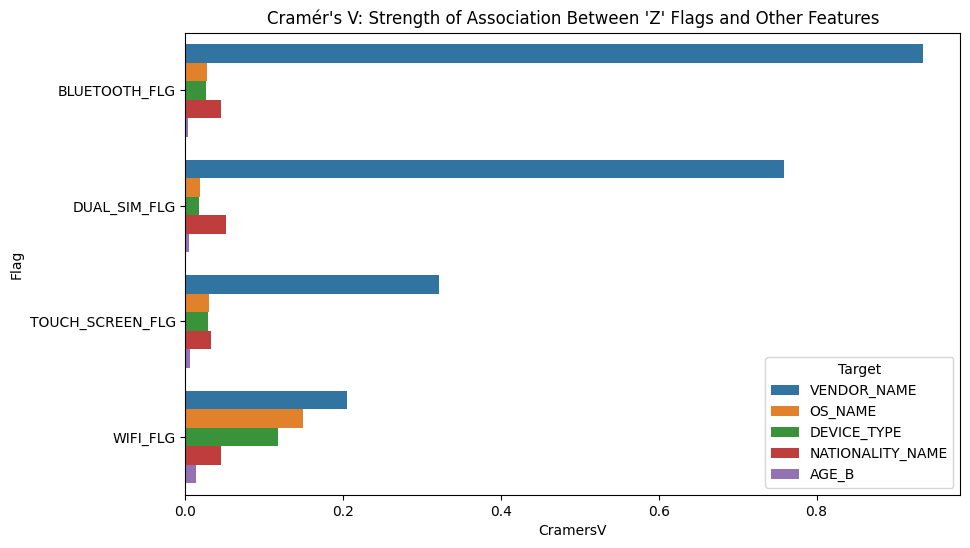

In [202]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='CramersV', y='Flag', hue='Target')
plt.title("Cramér's V: Strength of Association Between 'Z' Flags and Other Features")
plt.show()


In [203]:
flag_columns = ['WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

vendors_with_z = {}

for col in flag_columns:
    vendors = df[df[col] == 'Z']['VENDOR_NAME'].dropna().unique().tolist()
    vendors_with_z[col] = vendors

# Display vendors for each flag
for flag, vendors in vendors_with_z.items():
    print(f"\nVendors with 'Z' in {flag} ({len(vendors)} vendors):")
    print(vendors)



Vendors with 'Z' in WIFI_FLG (9 vendors):
['by2', 'cect', 'ck telecom', 'kenxinda', 'microsoft', 'noal technology', 'nokia', 'vell-com', 'zte']

Vendors with 'Z' in BLUETOOTH_FLG (6 vendors):
['by2', 'cect', 'ck telecom', 'eyang', 'vell-com', 'zte']

Vendors with 'Z' in TOUCH_SCREEN_FLG (4 vendors):
['aolixin technology', 'by2', 'google', 'nokia']

Vendors with 'Z' in DUAL_SIM_FLG (6 vendors):
['by2', 'cect', 'ck telecom', 'kenxinda', 'vell-com', 'zte']


In [204]:
flag_columns = ['WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

# Create a mask where any flag column has 'Z'
z_mask = df[flag_columns] == 'Z'

# Sum across the flag columns to count how many 'Z's per row
z_counts_per_row = z_mask.sum(axis=1)

# Add this count as a new column
df['Z_FLAG_COUNT'] = z_counts_per_row

# Group by vendor and sum how many rows have at least one 'Z'
z_counts_per_vendor = df[df['Z_FLAG_COUNT'] > 0].groupby('VENDOR_NAME')['Z_FLAG_COUNT'].count().sort_values(ascending=False)

# Display the result
print(z_counts_per_vendor)


VENDOR_NAME
nokia                 1891
microsoft              162
eyang                   49
ck telecom              15
aolixin technology       8
vell-com                 7
by2                      6
kenxinda                 5
noal technology          2
google                   2
cect                     1
zte                      1
Name: Z_FLAG_COUNT, dtype: int64


In [205]:
# Filter first 300 rows where any column has 'Z'
z_rows = df[df.isin(['Z']).any(axis=1)]

# Save to CSV
z_rows.to_csv('rows_with_Z.csv', index=False)


In [206]:
df[df['VENDOR_NAME'] == 'nokia'].OS_NAME.value_counts()

OS_NAME
proprietary    43181
other           4692
symbian          849
Name: count, dtype: int64

In [207]:
z_rows.MODEL_NAME.value_counts().to_dict().keys()

dict_keys(['3109 classic', '2323 classic', 'hd7', '6060', '7100 supernova', '6700 classic', '2660', '3500 classic', '6500 slide', '7020', 'c2-015', '7310 supernova', '5000', '7070 prism', '2710 navigation edition', '7610 supernova', '6131', '6555', '7700 king slider', '6085h', 'm1', 'z30', 'm5', 'x1', 'k100', 'x2-02', 'l50'])

By scraping GSMArena, we can extract features like Wi-Fi, Bluetooth, and Dual SIM. However, touchscreen info is often missing or unclear. An LLM is needed to infer touchscreen presence based on context (e.g., year, form factor).

In [208]:
z_rows = df[df.apply(lambda row: row.astype(str).str.contains('Z')).any(axis=1)]
print(f"Number of rows containing 'Z': {len(z_rows)}")

Number of rows containing 'Z': 5333


In [209]:
df.drop(columns=['Z_FLAG_COUNT'], inplace=True, errors='ignore')

Why?: Maybe I can fill Wi-Fi and Bluetootch, but Dual SIM will be fake

In [210]:
df = df[~df.apply(lambda row: row.astype(str).str.contains('Z')).any(axis=1)]

# Continue

In [211]:
# Ensure it's datetime (just in case)
df['CAL_DT'] = pd.to_datetime(df['CAL_DT'], errors='coerce')

# Sort by date
df_sorted1 = df.sort_values(by='CAL_DT')

# Display sorted DataFrame
df_sorted1.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
26050,2018-11-30,xperia e3 dual,sony xperia e3 dual,sony,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Male,NaN,PHL,Philippines,Non-Saudi,3,3.000000
110554,2018-11-30,desire 620g dual sim,htc desire 620g dual sim,htc,google,android,smartphone,Y,y,N,Y,Y,Y,Y,Male,36-55,AFG,Afghanistan,Non-Saudi,2,2.000000
191667,2018-11-30,e5-00,nokia e5-00,nokia,symbian ltd,symbian,smartphone,Y,Y,N,Y,Y,N,N,NaN,36-55,NaN,NaN,NaN,3,3.000000
181066,2018-11-30,105,nokia 105,nokia,nokia,proprietary,mobile phone,NaN,N,n,N,N,N,N,Female,18-25,MLI,Mali,Non-Saudi,34,5.333333
181065,2018-11-30,105,nokia 105,nokia,nokia,proprietary,mobile phone,NaN,N,n,N,N,N,N,Female,18-25,MLI,Mali,Non-Saudi,4,4.000000


In [212]:
df_sorted1.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
26050,2018-11-30,xperia e3 dual,sony xperia e3 dual,sony,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Male,NaN,PHL,Philippines,Non-Saudi,3,3.000000
110554,2018-11-30,desire 620g dual sim,htc desire 620g dual sim,htc,google,android,smartphone,Y,y,N,Y,Y,Y,Y,Male,36-55,AFG,Afghanistan,Non-Saudi,2,2.000000
191667,2018-11-30,e5-00,nokia e5-00,nokia,symbian ltd,symbian,smartphone,Y,Y,N,Y,Y,N,N,NaN,36-55,NaN,NaN,NaN,3,3.000000
181066,2018-11-30,105,nokia 105,nokia,nokia,proprietary,mobile phone,NaN,N,n,N,N,N,N,Female,18-25,MLI,Mali,Non-Saudi,34,5.333333
181065,2018-11-30,105,nokia 105,nokia,nokia,proprietary,mobile phone,NaN,N,n,N,N,N,N,Female,18-25,MLI,Mali,Non-Saudi,4,4.000000


In [213]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
0,2020-07-31,one touch 1010,alcatel one touch 1010,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,26-35,EGY,Egypt,Non-Saudi,1,1.0
1,2019-03-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,NaN,IDN,Indonesia,Non-Saudi,1,1.0
2,2020-02-29,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,36-55,ERI,Eritrea,Non-Saudi,1,1.0
3,2019-09-30,one touch 1010,alcatel one touch 1010,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,>55,LKA,Sri Lanka,Non-Saudi,1,1.0
4,2020-01-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,NaN,PHL,Philippines,Non-Saudi,1,1.0


In [214]:
df.isna().sum()

CAL_DT                     1942
MODEL_NAME                   23
BRAND_FULL_NAME              34
BRAND_NAME                   83
VENDOR_NAME                  83
OS_NAME                       0
DEVICE_TYPE                   0
_2G_FLG                    1971
_3G_FLG                    1965
_4G_FLG                    1959
WIFI_FLG                   1970
BLUETOOTH_FLG              1961
TOUCH_SCREEN_FLG           1955
DUAL_SIM_FLG               1965
GENDER_TYPE_CD            25047
AGE_B                     31473
NATIONALITY_CD            11144
NATIONALITY_NAME          11128
SAUDI_NON_SAUDI           11144
DEVICE_COUNT               1955
DEVICE_COUNT_processed     1955
dtype: int64

In [215]:
df.to_csv('check.csv', index=False)


In [216]:
df.GENDER_TYPE_CD.value_counts()

GENDER_TYPE_CD
Male      113245
Female     53108
X            199
Name: count, dtype: int64

In [217]:
df[df['GENDER_TYPE_CD'] == 'X'].head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
1167,2020-10-31,1066 dual sim,alcatel 1066 dual sim,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,Y,X,18-25,KWT,Kuwait,Non-Saudi,1,1.0
1168,2019-06-30,one touch 1050 dual sim,alcatel one touch 1050 dual sim,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,Y,X,>55,KWT,Kuw,Non-Saudi,2,2.0
3575,2019-06-30,2002d,alcatel 2002d,alcatel,alcatel,proprietary,mobile phone,Y,n,N,N,Y,N,Y,X,>55,NaN,NaN,NaN,3,3.0
4223,2019-07-31,f18,archos f18,archos,archos,proprietary,mobile phone,Y,N,N,N,Y,N,Y,X,36-55,GBR,United Kingdom,Non-Saudi,3,3.0
4348,2019-08-31,b312,beasy b312,beasy,beasy,proprietary,mobile phone,Y,N,N,N,Y,N,Y,X,36-55,ETH,Ethiopia,Non-Saudi,1,1.0


In [218]:
df['GENDER_TYPE_CD'] = df['GENDER_TYPE_CD'].replace('X', np.nan)

In [219]:
flag_cols = [
    '_2G_FLG', '_3G_FLG', '_4G_FLG', 
    'WIFI_FLG', 'BLUETOOTH_FLG', 
    'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG'
]

# Convert to lowercase safely (only if value is string)
df[flag_cols] = df[flag_cols].applymap(
    lambda x: x.lower() if isinstance(x, str) else x
)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_10776\2987273552.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[flag_cols] = df[flag_cols].applymap(


In [220]:
df.isna().sum()

CAL_DT                     1942
MODEL_NAME                   23
BRAND_FULL_NAME              34
BRAND_NAME                   83
VENDOR_NAME                  83
OS_NAME                       0
DEVICE_TYPE                   0
_2G_FLG                    1971
_3G_FLG                    1965
_4G_FLG                    1959
WIFI_FLG                   1970
BLUETOOTH_FLG              1961
TOUCH_SCREEN_FLG           1955
DUAL_SIM_FLG               1965
GENDER_TYPE_CD            25246
AGE_B                     31473
NATIONALITY_CD            11144
NATIONALITY_NAME          11128
SAUDI_NON_SAUDI           11144
DEVICE_COUNT               1955
DEVICE_COUNT_processed     1955
dtype: int64

# Plan

1)

In [221]:
from sklearn.preprocessing import LabelEncoder

# 1. Columns to include
flag_cols = ['_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']
support_cols = ['BRAND_FULL_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']
all_cols = flag_cols + support_cols

# 2. Work on a copy
df_knn = df[all_cols].copy()

# 3. Encode categorical (support) columns
encoders = {}
for col in support_cols:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    encoders[col] = le  # Save encoder for future inverse transform if needed

# 4. Encode flags (if not already binary)
for col in flag_cols:
    if df_knn[col].dtype != 'float' and df_knn[col].dtype != 'int':
        le = LabelEncoder()
        df_knn[col] = le.fit_transform(df_knn[col].astype(str))
        encoders[col] = le

# 5. Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=all_cols)

# 6. Round flags (in case KNN gives float like 0.67, 1.0)
df_knn_imputed[flag_cols] = df_knn_imputed[flag_cols].round().astype(int)

# 7. Copy back imputed flag values to original dataframe
for col in flag_cols:
    df[col] = df[col].fillna(df_knn_imputed[col])

print("✅ Imputation complete. Missing values in flags are filled.")

✅ Imputation complete. Missing values in flags are filled.


In [222]:
from sklearn.preprocessing import LabelEncoder

# 1. Columns to include
flag_cols = ['_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']
support_cols = ['BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']
all_cols = flag_cols + support_cols

# 2. Work on a copy
df_knn = df[all_cols].copy()

# 3. Encode categorical (support) columns
encoders = {}
for col in support_cols:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    encoders[col] = le  # Save encoder for future inverse transform if needed

# 4. Encode flags (if not already binary)
for col in flag_cols:
    if df_knn[col].dtype != 'float' and df_knn[col].dtype != 'int':
        le = LabelEncoder()
        df_knn[col] = le.fit_transform(df_knn[col].astype(str))
        encoders[col] = le

# 5. Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=all_cols)

# 6. Round flags (in case KNN gives float like 0.67, 1.0)
df_knn_imputed[flag_cols] = df_knn_imputed[flag_cols].round().astype(int)

# 7. Copy back imputed flag values to original dataframe
for col in flag_cols:
    df[col] = df[col].fillna(df_knn_imputed[col])

print("✅ Imputation complete. Missing values in flags are filled.")

✅ Imputation complete. Missing values in flags are filled.


2)

In [223]:
# Rule 1: Fill BRAND_NAME using first word from BRAND_FULL_NAME
df['BRAND_NAME'] = df['BRAND_NAME'].fillna(
    df['BRAND_FULL_NAME'].str.split().str[0]
)

# Rule 2: KNN Imputer for remaining nulls
still_null_mask = df['BRAND_NAME'].isnull()

# Columns to use for KNN
knn_cols = ['BRAND_NAME', 'MODEL_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE',
            '_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG',
            'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

df_knn = df[knn_cols].copy()

# Label encode all columns
encoders = {}
for col in knn_cols:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    encoders[col] = le

# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=knn_cols)

# Decode BRAND_NAME column
brand_col_encoded = df_knn_imputed['BRAND_NAME'].round().astype(int)
decoded_brands = encoders['BRAND_NAME'].inverse_transform(brand_col_encoded)

# Fill only where still null
df.loc[still_null_mask, 'BRAND_NAME'] = decoded_brands[still_null_mask]

print("✅ BRAND_NAME filled using first-word and KNN imputation.")


✅ BRAND_NAME filled using first-word and KNN imputation.


3)

In [224]:
# Columns to use in KNN
knn_cols_model = ['MODEL_NAME', 'CAL_DT', 'BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE',
                  '_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG',
                  'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

df_knn_model = df[knn_cols_model].copy()

# Label encode all columns
encoders_model = {}
for col in knn_cols_model:
    le = LabelEncoder()
    df_knn_model[col] = le.fit_transform(df_knn_model[col].astype(str))
    encoders_model[col] = le

# Apply KNN Imputer
imputer_model = KNNImputer(n_neighbors=5)
df_knn_imputed_model = pd.DataFrame(imputer_model.fit_transform(df_knn_model), columns=knn_cols_model)

# Decode MODEL_NAME column
model_col_encoded = df_knn_imputed_model['MODEL_NAME'].round().astype(int)
decoded_models = encoders_model['MODEL_NAME'].inverse_transform(model_col_encoded)

# Fill only the originally null values
model_null_mask = df['MODEL_NAME'].isnull()
df.loc[model_null_mask, 'MODEL_NAME'] = decoded_models[model_null_mask]

print("✅ MODEL_NAME filled using KNN Imputer.")


✅ MODEL_NAME filled using KNN Imputer.


4) Rerun 2 and 3

5)

In [225]:
# Fill BRAND_FULL_NAME only if it's null
df['BRAND_FULL_NAME'] = df['BRAND_FULL_NAME'].fillna(
    df['BRAND_NAME'].fillna('') + ' ' + df['MODEL_NAME'].fillna('')
)

# Optional: strip extra spaces
df['BRAND_FULL_NAME'] = df['BRAND_FULL_NAME'].str.strip()

7)

In [226]:
# Select relevant features
features = [
    'AGE_B', '_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG',
    'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG',
    'BRAND_FULL_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE',
    'GENDER_TYPE_CD'
]

df_knn = df[features].copy()

# Encode categorical columns
label_encoders = {}
for col in df_knn.columns:
    if df_knn[col].dtype == 'object' or col.endswith('_FLG'):
        le = LabelEncoder()
        df_knn[col] = df_knn[col].astype(str)
        df_knn[col] = df_knn[col].replace('nan', pd.NA)
        df_knn[col] = le.fit_transform(df_knn[col].astype(str))
        label_encoders[col] = le

# Apply KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(df_knn)

# Replace only the nulls in GENDER_TYPE_CD
gender_col_index = df_knn.columns.get_loc('GENDER_TYPE_CD')
df.loc[df['GENDER_TYPE_CD'].isna(), 'GENDER_TYPE_CD'] = label_encoders['GENDER_TYPE_CD'].inverse_transform(
    imputed_array[df['GENDER_TYPE_CD'].isna(), gender_col_index].astype(int)
)

In [227]:
# Select relevant features
features = [
    'AGE_B', '_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG',
    'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG',
    'BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE',
    'GENDER_TYPE_CD'
]

df_knn = df[features].copy()

# Encode categorical columns
label_encoders = {}
for col in df_knn.columns:
    if df_knn[col].dtype == 'object' or col.endswith('_FLG'):
        le = LabelEncoder()
        df_knn[col] = df_knn[col].astype(str)
        df_knn[col] = df_knn[col].replace('nan', pd.NA)
        df_knn[col] = le.fit_transform(df_knn[col].astype(str))
        label_encoders[col] = le

# Apply KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(df_knn)

# Replace only the nulls in GENDER_TYPE_CD
gender_col_index = df_knn.columns.get_loc('GENDER_TYPE_CD')
df.loc[df['GENDER_TYPE_CD'].isna(), 'GENDER_TYPE_CD'] = label_encoders['GENDER_TYPE_CD'].inverse_transform(
    imputed_array[df['GENDER_TYPE_CD'].isna(), gender_col_index].astype(int)
)

8)

In [228]:
# Select features for KNN
features = [
    'AGE_B', 'GENDER_TYPE_CD', '_2G_FLG', '_3G_FLG', '_4G_FLG',
    'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG',
    'BRAND_FULL_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE'
]

df_knn = df[features].copy()

# Replace invalid or placeholder values if needed
df_knn['GENDER_TYPE_CD'] = df_knn['GENDER_TYPE_CD'].replace('X', pd.NA)

# Encode categorical columns
label_encoders = {}
for col in df_knn.columns:
    if df_knn[col].dtype == 'object' or col.endswith('_FLG'):
        le = LabelEncoder()
        df_knn[col] = df_knn[col].astype(str).replace('nan', pd.NA)
        df_knn[col] = le.fit_transform(df_knn[col].astype(str))
        label_encoders[col] = le

# Apply KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(df_knn)

# Replace only nulls in AGE_B
age_col_index = df_knn.columns.get_loc('AGE_B')
df.loc[df['AGE_B'].isna(), 'AGE_B'] = imputed_data[df['AGE_B'].isna(), age_col_index]


In [229]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Step 1: Map AGE_B to ordinal integers
age_map = {'<18': 0, '18-25': 1, '26-35': 2, '36-55': 3, '>55': 4}
reverse_age_map = {v: k for k, v in age_map.items()}

df_knn = df.copy()

# Map AGE_B
df_knn['AGE_B'] = df_knn['AGE_B'].map(age_map)

# Step 2: Select features
features = [
    'AGE_B', 'GENDER_TYPE_CD', '_2G_FLG', '_3G_FLG', '_4G_FLG',
    'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG',
    'BRAND_FULL_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE'
]
df_knn = df_knn[features]

# Step 3: Encode categorical columns
label_encoders = {}
for col in df_knn.columns:
    if col != 'AGE_B' and (df_knn[col].dtype == 'object' or col.endswith('_FLG')):
        le = LabelEncoder()
        df_knn[col] = df_knn[col].astype(str).replace('nan', pd.NA)
        df_knn[col] = le.fit_transform(df_knn[col].astype(str))
        label_encoders[col] = le

# Step 4: Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(df_knn)

# Step 5: Replace only nulls in AGE_B
age_col_index = df_knn.columns.get_loc('AGE_B')
df.loc[df['AGE_B'].isna(), 'AGE_B'] = [
    reverse_age_map[int(round(val))] for val in imputed_array[df['AGE_B'].isna(), age_col_index]
]

skip

In [230]:
df.isna().sum()

CAL_DT                     1942
MODEL_NAME                    0
BRAND_FULL_NAME               0
BRAND_NAME                    0
VENDOR_NAME                  83
OS_NAME                       0
DEVICE_TYPE                   0
_2G_FLG                     109
_3G_FLG                     140
_4G_FLG                     112
WIFI_FLG                    113
BLUETOOTH_FLG                87
TOUCH_SCREEN_FLG             97
DUAL_SIM_FLG                115
GENDER_TYPE_CD                0
AGE_B                         0
NATIONALITY_CD            11144
NATIONALITY_NAME          11128
SAUDI_NON_SAUDI           11144
DEVICE_COUNT               1955
DEVICE_COUNT_processed     1955
dtype: int64

In [231]:
# Select relevant columns
features = ['VENDOR_NAME', 'BRAND_FULL_NAME', 'OS_NAME', 'DEVICE_TYPE']
df_knn = df[features].copy()

# Encode categorical variables using LabelEncoder
label_encoders = {}
for col in features:
    le = LabelEncoder()
    # Convert to string first to avoid issues with NaN (will be encoded as a separate label)
    df_knn[col] = df_knn[col].astype(str).fillna('nan')
    df_knn[col] = le.fit_transform(df_knn[col])
    label_encoders[col] = le

# Initialize KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Apply imputer
imputed_array = imputer.fit_transform(df_knn)

# The imputed VENDOR_NAME is the first column
imputed_vendor_encoded = imputed_array[:, 0]

# Decode back to original categorical values
imputed_vendor = label_encoders['VENDOR_NAME'].inverse_transform(imputed_vendor_encoded.astype(int))

# Update the original dataframe, only filling missing VENDOR_NAME values
df.loc[df['VENDOR_NAME'].isna(), 'VENDOR_NAME'] = imputed_vendor[df['VENDOR_NAME'].isna()]


9)

In [232]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
0,2020-07-31,one touch 1010,alcatel one touch 1010,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,26-35,EGY,Egypt,Non-Saudi,1,1.0
1,2019-03-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,4.0,IDN,Indonesia,Non-Saudi,1,1.0
2,2020-02-29,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,36-55,ERI,Eritrea,Non-Saudi,1,1.0
3,2019-09-30,one touch 1010,alcatel one touch 1010,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,>55,LKA,Sri Lanka,Non-Saudi,1,1.0
4,2020-01-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,4.0,PHL,Philippines,Non-Saudi,1,1.0


In [233]:
unmatched_names = df[df['NATIONALITY_CD'].isna() & df['NATIONALITY_NAME'].notna()]['NATIONALITY_NAME'].unique()
print(unmatched_names)

['Atlantis' 'Eth' 'Kuwait - Without' 'Kuw' 'Eri']


In [234]:
to_null_nationalities = {
    'Atlantis': None,
    'Eth': None,
    'Kuwait - Without': None,
    'Kuw': None,
    'Eri': None,
}
df['NATIONALITY_NAME'] = df['NATIONALITY_NAME'].replace(to_null_nationalities)

In [235]:
df.isna().sum()

CAL_DT                     1942
MODEL_NAME                    0
BRAND_FULL_NAME               0
BRAND_NAME                    0
VENDOR_NAME                   0
OS_NAME                       0
DEVICE_TYPE                   0
_2G_FLG                     109
_3G_FLG                     140
_4G_FLG                     112
WIFI_FLG                    113
BLUETOOTH_FLG                87
TOUCH_SCREEN_FLG             97
DUAL_SIM_FLG                115
GENDER_TYPE_CD                0
AGE_B                         0
NATIONALITY_CD            11144
NATIONALITY_NAME          11464
SAUDI_NON_SAUDI           11144
DEVICE_COUNT               1955
DEVICE_COUNT_processed     1955
dtype: int64

In [236]:
df['NATIONALITY_CD'] = df.apply(
    lambda row: nat_map.get(row['NATIONALITY_NAME'], row['NATIONALITY_CD']) 
    if pd.isna(row['NATIONALITY_CD']) and pd.notna(row['NATIONALITY_NAME']) 
    else row['NATIONALITY_CD'],
    axis=1
)

In [237]:
df.columns

Index(['CAL_DT', 'MODEL_NAME', 'BRAND_FULL_NAME', 'BRAND_NAME', 'VENDOR_NAME',
       'OS_NAME', 'DEVICE_TYPE', '_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG',
       'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG', 'GENDER_TYPE_CD',
       'AGE_B', 'NATIONALITY_CD', 'NATIONALITY_NAME', 'SAUDI_NON_SAUDI',
       'DEVICE_COUNT', 'DEVICE_COUNT_processed'],
      dtype='object')

In [238]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

# Assume df is your DataFrame

# Columns to use as features
feature_cols = ['BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE', 'GENDER_TYPE_CD', 'AGE_B']

# Target column
target_col = 'NATIONALITY_NAME'

# Separate rows where NATIONALITY_NAME is missing or not
missing_mask = df[target_col].isnull()

# Prepare features dataframe and convert to string (to encode categorical)
X = df[feature_cols].astype(str)

# Encode target labels for non-missing rows
label_enc = LabelEncoder()
y = df.loc[~missing_mask, target_col]
y_encoded = label_enc.fit_transform(y)

# One-hot encode features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Split features into train and test sets based on missingness in target
X_train = X_encoded[~missing_mask]
X_test = X_encoded[missing_mask]

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_encoded)

# Predict missing NATIONALITY_NAME
y_pred_encoded = knn.predict(X_test)
y_pred = label_enc.inverse_transform(y_pred_encoded)

# Fill missing NATIONALITY_NAME values in original df
df.loc[missing_mask, target_col] = y_pred



In [239]:
df.isna().sum()

CAL_DT                     1942
MODEL_NAME                    0
BRAND_FULL_NAME               0
BRAND_NAME                    0
VENDOR_NAME                   0
OS_NAME                       0
DEVICE_TYPE                   0
_2G_FLG                     109
_3G_FLG                     140
_4G_FLG                     112
WIFI_FLG                    113
BLUETOOTH_FLG                87
TOUCH_SCREEN_FLG             97
DUAL_SIM_FLG                115
GENDER_TYPE_CD                0
AGE_B                         0
NATIONALITY_CD            11144
NATIONALITY_NAME              0
SAUDI_NON_SAUDI           11144
DEVICE_COUNT               1955
DEVICE_COUNT_processed     1955
dtype: int64

In [240]:
# Reverse nat_map to map NATIONALITY_NAME -> NATIONALITY_CD
nat_map_reverse = {v: k for k, v in nat_map.items()}

# Function to fill NATIONALITY_CD from NATIONALITY_NAME using reversed map
def fill_nationality_cd(row):
    if pd.isna(row['NATIONALITY_CD']) and pd.notna(row['NATIONALITY_NAME']):
        return nat_map_reverse.get(row['NATIONALITY_NAME'], row['NATIONALITY_CD'])
    return row['NATIONALITY_CD']

# Apply the function
df['NATIONALITY_CD'] = df.apply(fill_nationality_cd, axis=1)


In [241]:
def fill_saudi_non_saudi(nationality):
    if pd.isna(nationality):
        return pd.NA  # Keep NaN as is
    elif nationality.strip().lower() == 'saudi arabia':
        return 'Saudi'
    else:
        return 'Non-Saudi'

df['SAUDI_NON_SAUDI'] = df['NATIONALITY_NAME'].apply(fill_saudi_non_saudi)


In [242]:
df.shape

(191599, 21)

In [125]:
df.isna().sum()

CAL_DT                    1942
MODEL_NAME                   0
BRAND_FULL_NAME              0
BRAND_NAME                   0
VENDOR_NAME                  0
OS_NAME                      0
DEVICE_TYPE                  0
_2G_FLG                    109
_3G_FLG                    140
_4G_FLG                    112
WIFI_FLG                   113
BLUETOOTH_FLG               87
TOUCH_SCREEN_FLG            97
DUAL_SIM_FLG               115
GENDER_TYPE_CD               0
AGE_B                        0
NATIONALITY_CD              13
NATIONALITY_NAME             0
SAUDI_NON_SAUDI              0
DEVICE_COUNT              1955
DEVICE_COUNT_processed    1955
dtype: int64

In [126]:
# Step 1: Define features
features = ['BRAND_NAME', 'MODEL_NAME', 'OS_NAME', 'VENDOR_NAME', 'DEVICE_TYPE',
            '_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG',
            'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']
target = 'DEVICE_COUNT_processed'

# Step 2: Map flag values to 0/1
flag_map = {'y': 1, 'n': 0, 'Z': np.nan}
for col in ['_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']:
    df[col] = df[col].map(flag_map).astype('float')

# Step 3: Keep only rows with no NaNs in selected columns
required_cols = features + [target]
df_clean = df.dropna(subset=required_cols)


In [127]:
df.shape

(191599, 21)

In [443]:
df_clean.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
0,2020-07-31,one touch 1010,alcatel one touch 1010,alcatel,alcatel,proprietary,mobile phone,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Female,26-35,EGY,Egypt,Non-Saudi,1,1.0
1,2019-03-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Female,4.0,IDN,Indonesia,Non-Saudi,1,1.0
2,2020-02-29,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Female,36-55,ERI,Eritrea,Non-Saudi,1,1.0
3,2019-09-30,one touch 1010,alcatel one touch 1010,alcatel,alcatel,proprietary,mobile phone,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Female,>55,LKA,Sri Lanka,Non-Saudi,1,1.0
4,2020-01-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Female,4.0,PHL,Philippines,Non-Saudi,1,1.0


In [444]:

# Step 4: Split
X_train = df_clean[features]
y_train = df_clean[target]

# Step 5: Process prediction set
df_missing = df[df[target].isnull()]
X_predict = df_missing[features].dropna()
predict_index = X_predict.index

# Step 6: Build model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

cat_cols = ['BRAND_NAME', 'MODEL_NAME', 'OS_NAME', 'VENDOR_NAME', 'DEVICE_TYPE']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Step 7: Fit and predict
model.fit(X_train, y_train)
predicted_values = model.predict(X_predict)

# Step 8: Assign back to main DataFrame
df.loc[predict_index, target] = predicted_values


In [243]:
# Assuming your DataFrame is named df
df.iloc[:, -1].to_csv("last_column.csv", index=False)


In [244]:
new_col = pd.read_csv("last_column.csv")
df.iloc[:, -1] = new_col.values

In [130]:
df.isna().sum()

CAL_DT                    1942
MODEL_NAME                   0
BRAND_FULL_NAME              0
BRAND_NAME                   0
VENDOR_NAME                  0
OS_NAME                      0
DEVICE_TYPE                  0
_2G_FLG                   1971
_3G_FLG                   1965
_4G_FLG                   1959
WIFI_FLG                  1970
BLUETOOTH_FLG             1961
TOUCH_SCREEN_FLG          1955
DUAL_SIM_FLG              1965
GENDER_TYPE_CD               0
AGE_B                        0
NATIONALITY_CD              13
NATIONALITY_NAME             0
SAUDI_NON_SAUDI              0
DEVICE_COUNT              1955
DEVICE_COUNT_processed    1955
dtype: int64

In [564]:
df.to_csv("version_one.csv", index=False)

In [565]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
0,2020-07-31,one touch 1010,alcatel one touch 1010,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,26-35,EGY,Egypt,Non-Saudi,1,1.0
1,2019-03-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,4.0,IDN,Indonesia,Non-Saudi,1,1.0
2,2020-02-29,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,36-55,ERI,Eritrea,Non-Saudi,1,1.0
3,2019-09-30,one touch 1010,alcatel one touch 1010,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,>55,LKA,Sri Lanka,Non-Saudi,1,1.0
4,2020-01-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,4.0,PHL,Philippines,Non-Saudi,1,1.0


In [245]:
def fill_cal_dt(group):
    if len(group) > 1:
        # Backward fill first
        group = group.bfill()
        # Forward fill for any remaining nulls
        group = group.ffill()
    return group

df['CAL_DT'] = df.groupby('MODEL_NAME')['CAL_DT'].transform(fill_cal_dt)

print("Remaining nulls in CAL_DT:", df['CAL_DT'].isnull().sum())


Remaining nulls in CAL_DT: 8


In [572]:
df.isna().sum()

CAL_DT                       4
MODEL_NAME                   0
BRAND_FULL_NAME              0
BRAND_NAME                   0
VENDOR_NAME                  0
OS_NAME                      0
DEVICE_TYPE                  0
_2G_FLG                    109
_3G_FLG                    140
_4G_FLG                    112
WIFI_FLG                   113
BLUETOOTH_FLG               87
TOUCH_SCREEN_FLG            97
DUAL_SIM_FLG               115
GENDER_TYPE_CD               0
AGE_B                        0
NATIONALITY_CD              13
NATIONALITY_NAME             0
SAUDI_NON_SAUDI              0
DEVICE_COUNT              1955
DEVICE_COUNT_processed     118
dtype: int64

In [246]:
df['DEVICE_COUNT'] = df['DEVICE_COUNT_processed']

In [247]:
df.drop('DEVICE_COUNT_processed', axis=1, inplace=True)

In [576]:
df.isna().sum()

CAL_DT                4
MODEL_NAME            0
BRAND_FULL_NAME       0
BRAND_NAME            0
VENDOR_NAME           0
OS_NAME               0
DEVICE_TYPE           0
_2G_FLG             109
_3G_FLG             140
_4G_FLG             112
WIFI_FLG            113
BLUETOOTH_FLG        87
TOUCH_SCREEN_FLG     97
DUAL_SIM_FLG        115
GENDER_TYPE_CD        0
AGE_B                 0
NATIONALITY_CD       13
NATIONALITY_NAME      0
SAUDI_NON_SAUDI       0
DEVICE_COUNT        118
dtype: int64

In [577]:
df.to_csv("version_two.csv", index=False)

In [248]:
df = df.dropna()

In [581]:
df.isna().sum()

CAL_DT              0
MODEL_NAME          0
BRAND_FULL_NAME     0
BRAND_NAME          0
VENDOR_NAME         0
OS_NAME             0
DEVICE_TYPE         0
_2G_FLG             0
_3G_FLG             0
_4G_FLG             0
WIFI_FLG            0
BLUETOOTH_FLG       0
TOUCH_SCREEN_FLG    0
DUAL_SIM_FLG        0
GENDER_TYPE_CD      0
AGE_B               0
NATIONALITY_CD      0
NATIONALITY_NAME    0
SAUDI_NON_SAUDI     0
DEVICE_COUNT        0
dtype: int64

In [583]:
data.shape

(202000, 20)

In [582]:
df.shape

(190725, 20)

In [260]:
df.to_csv("last_version.csv", index=False)

------

In [3]:
import pandas as pd

In [10]:
df = pd.read_csv('version_one.csv')

In [7]:
data = pd.read_csv('1.csv')

In [12]:
data.isna().sum()

CAL_DT               2054
MODEL_NAME           2058
BRAND_FULL_NAME      2053
BRAND_NAME           2059
VENDOR_NAME          2066
OS_NAME              2061
DEVICE_TYPE          2064
_2G_FLG              2067
_3G_FLG              2068
_4G_FLG              2069
WIFI_FLG             2054
BLUETOOTH_FLG        2045
TOUCH_SCREEN_FLG     2062
DUAL_SIM_FLG         2057
GENDER_TYPE_CD      25834
AGE_B                2066
NATIONALITY_CD      22513
NATIONALITY_NAME     2067
SAUDI_NON_SAUDI      2052
DEVICE_COUNT         2052
dtype: int64

In [11]:
df.shape

(191599, 21)

In [257]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT
0,2020-07-31,one touch 1010,alcatel one touch 1010,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,26-35,EGY,Egypt,Non-Saudi,1.0
1,2019-03-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,4.0,IDN,Indonesia,Non-Saudi,1.0
2,2020-02-29,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,36-55,ERI,Eritrea,Non-Saudi,1.0
3,2019-09-30,one touch 1010,alcatel one touch 1010,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,>55,LKA,Sri Lanka,Non-Saudi,1.0
4,2020-01-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,n,Female,4.0,PHL,Philippines,Non-Saudi,1.0


In [259]:
df['AGE_B'] = df['AGE_B'].replace(4.0, '>55')